# **COMPARADOR DE MODELOS**

In [84]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

In [2]:
X_train = pd.read_csv('../Data/X_train3.csv', index_col=0)
X_test = pd.read_csv('../Data/X_test3.csv', index_col= 0)
y_train = pd.read_csv('../Data/y_train.csv', index_col= 0)
y_test = pd.read_csv('../Data/y_test.csv', index_col= 0)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5917, 9)
(1480, 9)
(5917, 1)
(1480, 1)


Las relaciones lineales entre X_train y los precios de la vivienda se muestran en la siguiente gráfica:

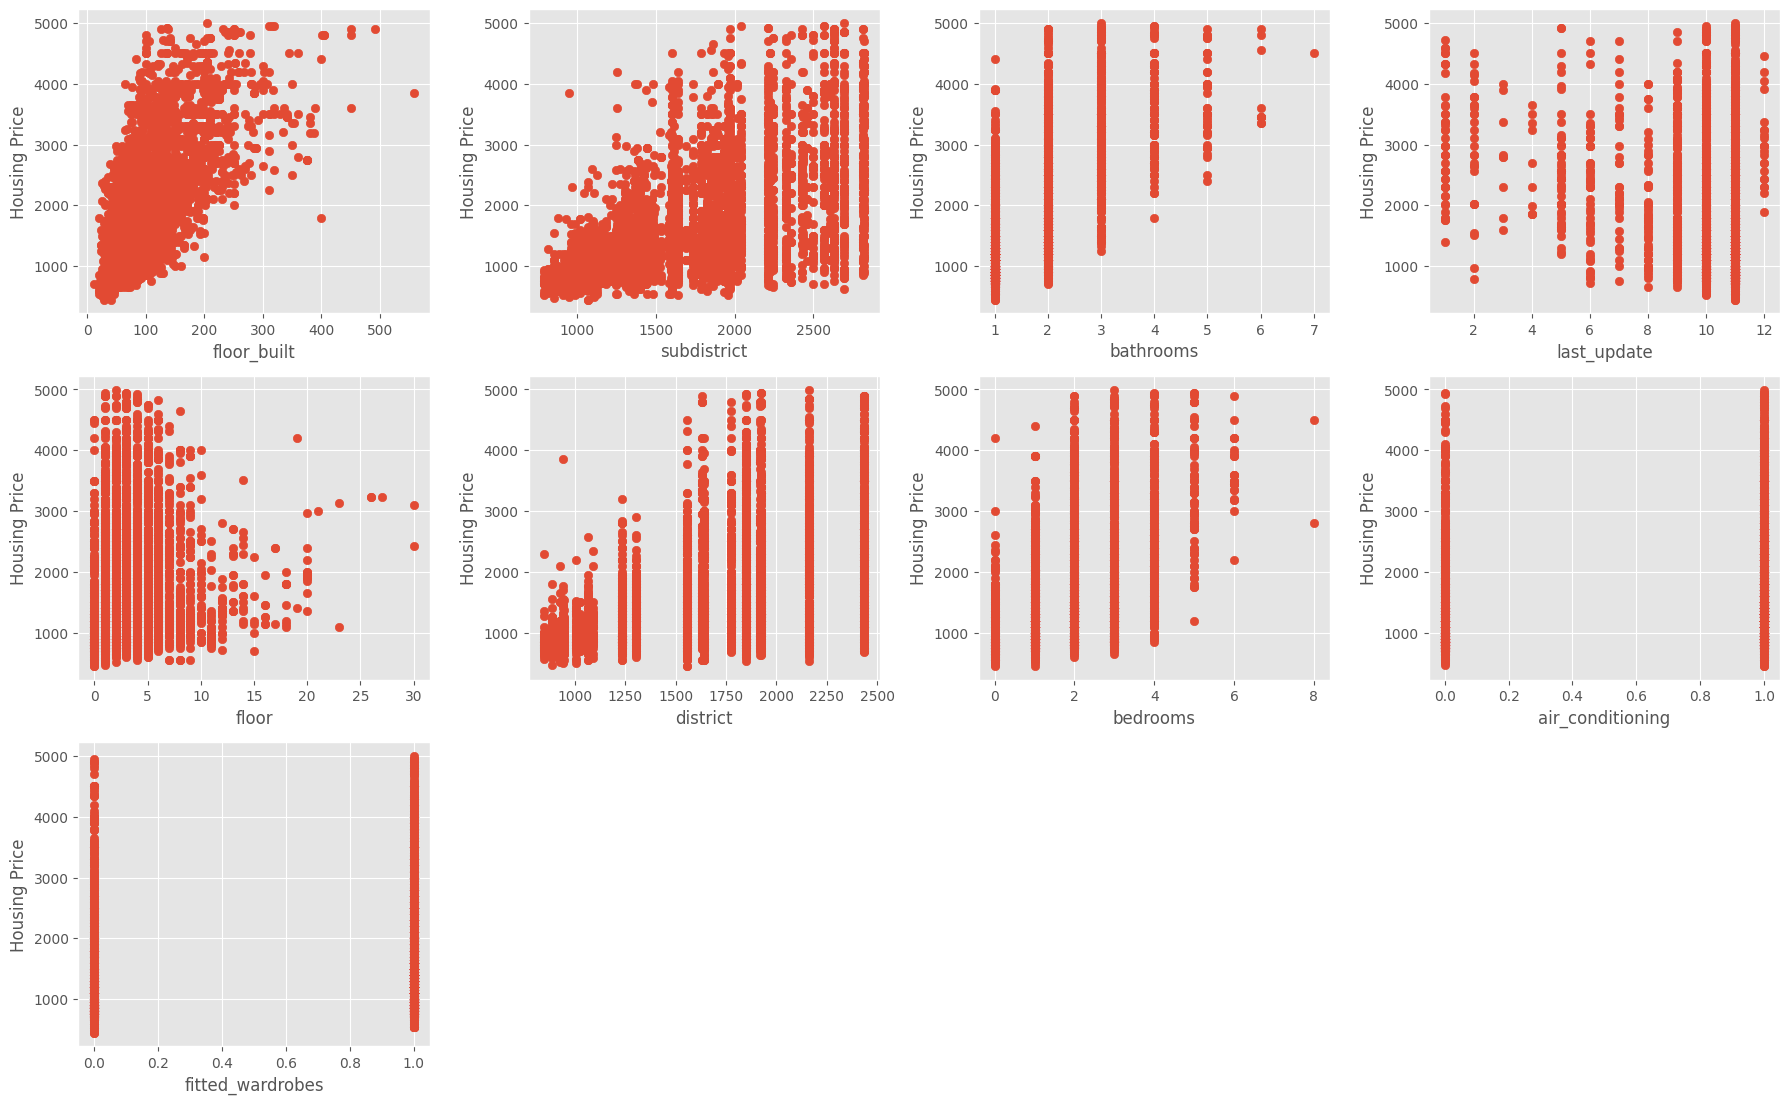

In [72]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(18,18))

for index, column in enumerate(X_train.columns):
    ax = fig.add_subplot(5,4,index+1)
    ax.scatter(X_train[column],y_train['price'])
    ax.set_ylabel('Housing Price', size=12)
    ax.set_xlabel(str(column), size=12)

plt.tight_layout()
plt.show()

Aparentemente se ven escasas relaciones lineales entre las features y nuestro target. Los modelos que trabajan linealmente, como la Regresión Lineal, no parecen ser candidatos a ser el mejor modelo de predicción.

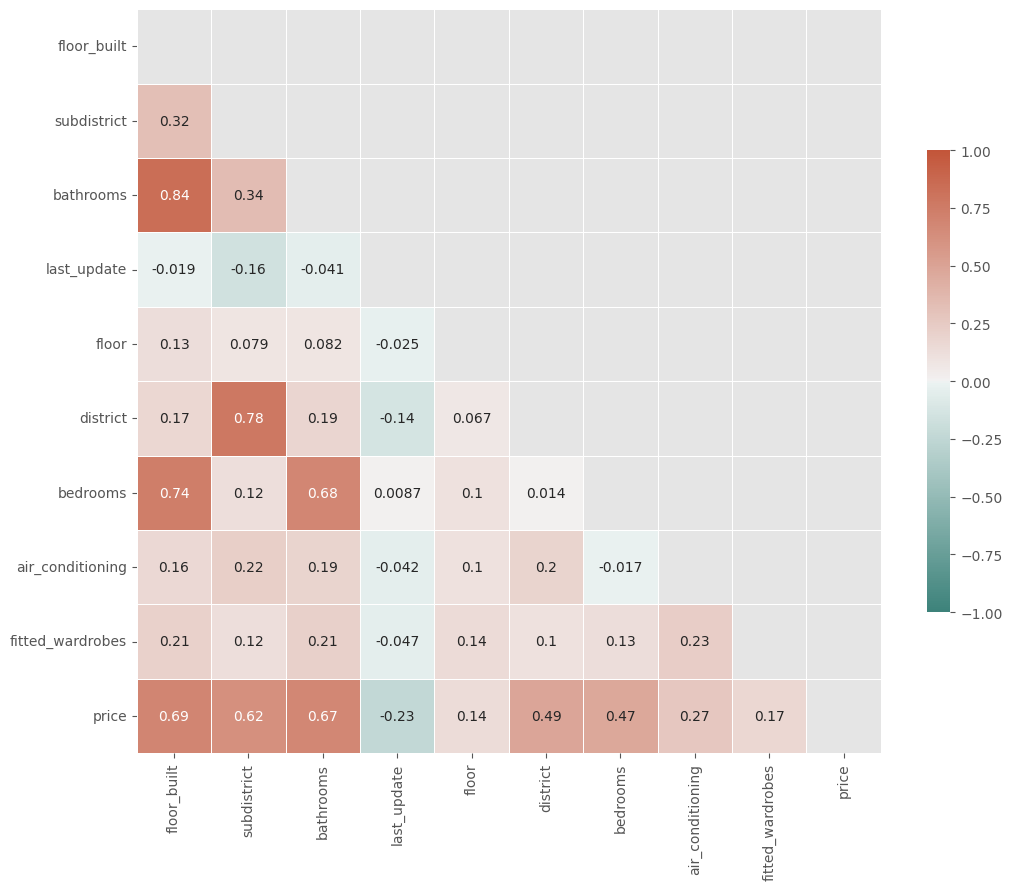

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# combinar X_train y y_train en un solo DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# generar la matriz de correlación
correlation = train_data.corr()

# crear la máscara triangular superior
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# crear el gráfico de correlación
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Estandarizamos X_train y X_test

In [74]:
scale = StandardScaler()
scale.fit(X_train)
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

In [9]:
results = []  #creamos una lista vacía donde se irán recogiendo los resultados de cada modelo

## - `1. Regresión Lineal`

### -Quitando pocas columnas:

In [85]:
#Primero vemos que tal la predicción en x_train para ver riesgo de overfitting
lr = LinearRegression()
lr.fit(X_train_scale, y_train)

r2_train = r2_score(y_train, lr.predict(X_train_scale)) 
mse = mean_squared_error(y_train, lr.predict(X_train_scale))
mae = mean_absolute_error(y_train, lr.predict(X_train_scale))

print('r2 train:', r2_train)
print("mse train:", mse)
print("mae train:", mae)

r2 train: 0.706334400696993
mse train: 249805.6002477949
mae train: 366.60133023040885


In [6]:
#Vamos a predecir X_test
prediccion = lr.predict(X_test_scale)

<AxesSubplot:xlabel='Prediction', ylabel='price'>

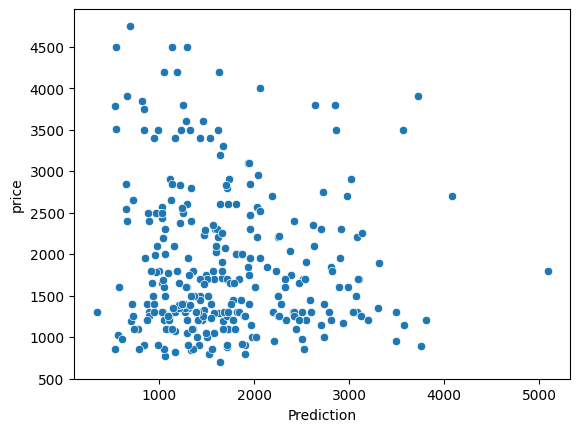

In [7]:
#Visualizamos las predicciones frente a los valores reales

y_pred = pd.DataFrame(lr.predict(X_test_scale), columns = ['Prediction'])
sns.scatterplot(x=y_pred['Prediction'], y=y_test['price'])

Vemos que no se ajustan muy bien las predicciones a los valores reales.

In [86]:
#calculamos el error y score en xtest

r2_test = r2_score(y_test, lr.predict(X_test_scale)) 
mse = mean_squared_error(y_test, lr.predict(X_test_scale))
mae = mean_absolute_error(y_test, lr.predict(X_test_scale))

print('r2 test:', r2_test)
print("mse test:", mse)
print("mae test:", mae)

r2 test: 0.6795320995418535
mse test: 268943.20890064014
mae test: 373.4957182140452


In [10]:
model1_results = {'Model': 'Regresion Lineal',
                 'Best Params': '--',
                 'Train score': r2_train,
                 'Test score': r2_test }

results.append(model1_results)

## - `2. Regularización`

In [11]:
#Hacemos un GridSearchCV de todos los modelos de Regularización para ver cual de ellos sería el mejor modelo con los mejores parámetros


Reg = Pipeline(steps=[("scaler", StandardScaler()), ("regressor", None)])

ridge_params = {
    'regressor': [Ridge()],
    'regressor__alpha': np.logspace(-10,10,20)
}

lasso_params = {
    'regressor': [Lasso()],
    'regressor__alpha': np.logspace(-10,10,20)
}

elasticnet_params = {
    'regressor': [ElasticNet()],
    'regressor__alpha': np.logspace(-10,10,20),
    'regressor__l1_ratio': np.arange(0,1.05,0.05)
}

search_space = [ridge_params, lasso_params, elasticnet_params]

grid = GridSearchCV(Reg,
                   search_space,
                   scoring="neg_mean_absolute_error",
                   cv = 10,
                   n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', None)]),
             n_jobs=-1,
             param_grid=[{'regressor': [Ridge()],
                          'regressor__alpha': array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.281...
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10]),
                          'regressor__l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}],
             scoring=

In [12]:
grid.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', Lasso(alpha=3.359818286283774))])

In [13]:
grid.best_score_  #neg mean absolute error


-366.80499676007105

In [14]:
reg_params = grid.best_params_

In [89]:
reg_train = grid.best_estimator_.score(X_train, y_train)
reg_test = grid.best_estimator_.score(X_test, y_test)
print(reg_train)
print(reg_test)

0.7062473435671592
0.6791247770284143


In [91]:
mse = mean_squared_error(y_train, grid.best_estimator_.predict(X_train))
mae = mean_absolute_error(y_train, grid.best_estimator_.predict(X_train))
mset = mean_squared_error(y_test, grid.best_estimator_.predict(X_test))
maet = mean_absolute_error(y_test, grid.best_estimator_.predict(X_test))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 249879.6550864468
mae train: 366.2203400339338
mse test: 269285.0422751066
mae test: 373.7224988948819


In [16]:
model2_results = {'Model': 'Regularizacion',
                 'Best Params': list(reg_params.values())[0] ,
                 'Train score': reg_train,
                 'Test score': reg_test}

results.append(model2_results)

------------

## - `3. KNN Regressor`

In [17]:
#Hacemos un GridSearchCV del KNN para obtener los mejores parámetros

knnreg = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())])

knn_params = {
    "knn__n_neighbors": np.arange(1,22,2),
    "knn__weights": ["uniform", "distance"],
    "knn__leaf_size": np.arange(10,51),
    "knn__p": [1, 2]
}

gs_knn = GridSearchCV(knnreg,
knn_params,
cv=10,
scoring = 'neg_mean_squared_error',
n_jobs = -1,
verbose = 1)

gs_knn.fit(X_train, y_train)


Fitting 10 folds for each of 1804 candidates, totalling 18040 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__leaf_size': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50]),
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
knn_params = gs_knn.best_estimator_
knn_params

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(leaf_size=42, n_neighbors=21, p=1,
                                     weights='distance'))])

In [19]:
knn_train = gs_knn.best_estimator_.score(X_train, y_train)
knn_train

0.9983927043761138

In [20]:
knn_test = gs_knn.best_estimator_.score(X_test, y_test)
knn_test

0.7321974126330439

In [92]:
mse = mean_squared_error(y_train, gs_knn.best_estimator_.predict(X_train))
mae = mean_absolute_error(y_train, gs_knn.best_estimator_.predict(X_train))
mset = mean_squared_error(y_test, gs_knn.best_estimator_.predict(X_test))
maet = mean_absolute_error(y_test, gs_knn.best_estimator_.predict(X_test))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 1367.2403204648429
mae train: 4.61933734115583
mse test: 224745.40225525503
mae test: 304.7835577644417


In [21]:
#Este modelo parece que tiene un grado elevado de overfitting. Se ha probado con distintos parámetros, pero no cambia, por lo que 
#no será elegido debido a que se ajusta demasiado a los datos de train y tiene poca capacidad de generalizar. 

In [22]:
model3_results = {'Model': 'KNN Regresor',
                 'Best Params': knn_params[1] ,
                 'Train score': knn_train,
                 'Test score': knn_test}

results.append(model3_results)

-------

## - `4. Arbol de decisión Regressor`

In [27]:
tree = DecisionTreeRegressor(random_state=42)  #no es necesario estandarizar los datos, no utilizamos pipeline

tree_params = {
    'max_depth': [2,5,7,10,15],
    'min_samples_split':[2,5,10,14],
    'min_samples_leaf': [2,5,7,9],
    'criterion': ["squared_error", "friedman_mse", "absolute_error"],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_tree = GridSearchCV(tree,
                         tree_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=1)

grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [2, 5, 7, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 7, 9],
                         'min_samples_split': [2, 5, 10, 14]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
tree_params = grid_tree.best_estimator_
tree_params

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=9,
                      random_state=42)

In [29]:
tree_train = grid_tree.best_estimator_.score(X_train, y_train)
tree_train

0.8097376521471181

In [30]:
tree_test = grid_tree.best_estimator_.score(X_test, y_test)
tree_test

0.6971852112011179

In [93]:
mse = mean_squared_error(y_train, grid_tree.best_estimator_.predict(X_train))
mae = mean_absolute_error(y_train, grid_tree.best_estimator_.predict(X_train))
mset = mean_squared_error(y_test, grid_tree.best_estimator_.predict(X_test))
maet = mean_absolute_error(y_test, grid_tree.best_estimator_.predict(X_test))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 161845.99123203207
mae train: 274.4222766378024
mse test: 254128.35696090918
mae test: 340.3704262228397


In [31]:
model4_results = {'Model': 'Decision Tree',
                 'Best Params': tree_params ,
                 'Train score': tree_train,
                 'Test score': tree_test}

results.append(model4_results)

## - `5. SVM Regressor`

In [32]:
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())])

svr_params = {
    "svr__kernel": ['linear', 'poly', 'rbf', 'sigmoid'] ,
    "svr__degree": [2, 3, 4],
    "svr__gamma": ['scale', 'auto'],
    "svr__C": [0.1, 0.5, 1, 5] ,
    "svr__epsilon": [0.01, 0.1, 0.5, 1],
}

gs_svr = GridSearchCV(svr,
svr_params,
cv=10,
scoring = 'neg_mean_squared_error',
n_jobs = -1,
verbose = 1)

gs_svr.fit(X_train, y_train.to_numpy().ravel())

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 0.5, 1, 5], 'svr__degree': [2, 3, 4],
                         'svr__epsilon': [0.01, 0.1, 0.5, 1],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
svr_params = gs_svr.best_estimator_
svr_params

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', SVR(C=5, degree=2, kernel='linear'))])

In [34]:
svr_train = gs_svr.best_estimator_.score(X_train, y_train)
svr_train

0.6872636314339933

In [35]:
svr_test = gs_svr.best_estimator_.score(X_test, y_test)
svr_test

0.6550284097780451

In [94]:
mse = mean_squared_error(y_train, gs_svr.best_estimator_.predict(X_train))
mae = mean_absolute_error(y_train, gs_svr.best_estimator_.predict(X_train))
mset = mean_squared_error(y_test, gs_svr.best_estimator_.predict(X_test))
maet = mean_absolute_error(y_test, gs_svr.best_estimator_.predict(X_test))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 266028.08246647427
mae train: 355.4001720770759
mse test: 289507.20593610936
mae test: 364.87611848088676


In [36]:
model5_results = {'Model': 'SVR',
                 'Best Params': svr_params ,
                 'Train score': svr_train,
                 'Test score': svr_test}

results.append(model5_results)

In [37]:
#Como el parámetro más óptimo de Kernel ha salido lineal, vamos a probar también con un LinearSVR
from sklearn.svm import LinearSVR

sv = Pipeline([
    ("scaler", StandardScaler()),
    ("svr_lin", LinearSVR())])

svr_params = {
    'svr_lin__C': [0.01, 0.1, 1, 10],
    'svr_lin__epsilon': [0.01, 0.1, 1, 10],
    'svr_lin__max_iter': [1000, 5000, 7000, 10000],
    'svr_lin__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

gs_svlr = GridSearchCV(sv,
svr_params,
cv=10,
scoring = 'neg_mean_squared_error',
n_jobs = -1,
verbose = 1)

gs_svlr.fit(X_train, y_train.to_numpy().ravel())

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


c:\Users\jimea\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr_lin', LinearSVR())]),
             n_jobs=-1,
             param_grid={'svr_lin__C': [0.01, 0.1, 1, 10],
                         'svr_lin__epsilon': [0.01, 0.1, 1, 10],
                         'svr_lin__loss': ['epsilon_insensitive',
                                           'squared_epsilon_insensitive'],
                         'svr_lin__max_iter': [1000, 5000, 7000, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
svrl_params = gs_svlr.best_estimator_
svrl_params

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr_lin',
                 LinearSVR(C=10, epsilon=1,
                           loss='squared_epsilon_insensitive'))])

In [39]:
svrl_train = gs_svlr.best_estimator_.score(X_train, y_train)
svrl_train

0.7056820046624842

In [40]:
svrl_test = gs_svlr.best_estimator_.score(X_test, y_test) 
svrl_test

0.6794085212157286

In [41]:
model6_results = {'Model': 'LinearSVR',
                 'Best Params': svrl_params ,
                 'Train score': svrl_train,
                 'Test score': svrl_test}

results.append(model6_results)

## - `6. Random Forest`

In [42]:
forest = RandomForestRegressor(random_state=42)

# Definir los rangos de los hiperparámetros para buscar
forest_params = {
    'n_estimators': [50,100,130,200],
    'max_features': ['sqrt', 'log2', 'auto'],
    'max_depth':[3,10,15,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
}

# Definir la búsqueda en cuadrícula
gs_forest = GridSearchCV(forest, 
                         forest_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=1)

# Ajustar el modelo con los datos
gs_forest.fit(X_train, y_train.to_numpy().ravel())

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 130, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [43]:
forest_params = gs_forest.best_estimator_
forest_params

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=200,
                      random_state=42)

In [44]:
forest_train = gs_forest.best_estimator_.score(X_train,y_train)
forest_train

0.9693343480728126

In [45]:
forest_test = gs_forest.best_estimator_.score(X_test,y_test)
forest_test

0.7787556842769681

In [46]:
gs_forest.best_estimator_.feature_importances_

array([0.32768418, 0.2142912 , 0.19090238, 0.05304632, 0.04631702,
       0.09172719, 0.04884387, 0.01695015, 0.0102377 ])

In [47]:
#Vemos la importancia que da el modelo a las distintas features que hemos empleado
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature' : feature_names, 'importance' : gs_forest.best_estimator_.feature_importances_})
feature_importances

,feature,importance
0,floor_built,0.327684
1,subdistrict,0.214291
2,bathrooms,0.190902
3,last_update,0.053046
4,floor,0.046317
5,district,0.091727
6,bedrooms,0.048844
7,air_conditioning,0.016950
8,fitted_wardrobes,0.010238


In [65]:
model7_results = {'Model': 'RandomForest con 8 columnas',
                 'Best Params': forest_params ,
                 'Train score': forest_train,
                 'Test score': forest_test}

results.append(model7_results)

Vamos a probar a hacerlo solo con las tres primeras columnas:


In [60]:
X_train_new = X_train.drop(columns= ['fitted_wardrobes', 'air_conditioning', 'bedrooms', 'district', 'floor', 'last_update'])

In [61]:
X_test_new = X_test.drop(columns= ['fitted_wardrobes', 'air_conditioning', 'bedrooms', 'district', 'floor', 'last_update'])

In [62]:
forest = RandomForestRegressor(random_state=42)

# Definir los rangos de los hiperparámetros para buscar
forest_params = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth':[5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True],
    'max_leaf_nodes': [None, 10],
    'min_impurity_decrease': [0.0, 0.001]
}

# Definir la búsqueda en cuadrícula
gs_forest2 = GridSearchCV(forest, 
                         forest_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=1)

gs_forest2.fit(X_train_new, y_train.to_numpy().ravel())

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10],
                         'min_impurity_decrease': [0.0, 0.001],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
forest_params2 = gs_forest2.best_estimator_
forest_params2

RandomForestRegressor(max_depth=10, max_features='sqrt',
                      min_impurity_decrease=0.001, random_state=42)

In [68]:
forest_train2 = gs_forest2.best_estimator_.score(X_train_new,y_train)
forest_train2

0.8333754410255828

In [69]:
forest_test2 = gs_forest2.best_estimator_.score(X_test_new,y_test)
forest_test2

0.7161516675593069

Se ve que aunque la precision de prediccion disminuye de 0,77 a 0,71 en test, disminuímos el grado del posible overfitting, ya que en train, la precisión del modelo disminuye de 0,96 a 0,83. Con esto conseguimos que nuestro modelo generalice mejor a nuevos datos. 

In [96]:
mse = mean_squared_error(y_train, gs_forest2.best_estimator_.predict(X_train_new))
mae = mean_absolute_error(y_train, gs_forest2.best_estimator_.predict(X_train_new))
mset = mean_squared_error(y_test, gs_forest2.best_estimator_.predict(X_test_new))
maet = mean_absolute_error(y_test, gs_forest2.best_estimator_.predict(X_test_new))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 141738.58997927982
mae train: 268.7671573698121
mse test: 238211.31931953234
mae test: 341.8235371216131


In [70]:
model8_results = {'Model': 'RandomForest con 3 columnas',
                 'Best Params': forest_params2 ,
                 'Train score': forest_train2,
                 'Test score': forest_test2}

results.append(model8_results)

## - `7. AdaBoostRegressor`

Primero haremos un AdaBoostRegressor basado en árboles de decisión:

In [75]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(random_state=42))

param_dist = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'loss': ['linear', 'square', 'exponential'],
    'base_estimator__max_depth':[3, 5, 7],
    'base_estimator__min_samples_split': [2,5,10],
    'base_estimator__min_samples_leaf': [1,2,4]
}

ada_search_tree = RandomizedSearchCV(ada_reg, 
                                param_distributions=param_dist, 
                                n_iter=100, 
                                cv=10, 
                                random_state=42,
                                error_score='raise')

ada_search_tree.fit(X_train, y_train.to_numpy().ravel())

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42)),
                   n_iter=100,
                   param_distributions={'base_estimator__max_depth': [3, 5, 7],
                                        'base_estimator__min_samples_leaf': [1,
                                                                             2,
                                                                             4],
                                        'base_estimator__min_samples_split': [2,
                                                                              5,
                                                                              10],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        

In [76]:
ada_tree_params = ada_search_tree.best_estimator_
ada_tree_params

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42),
                  learning_rate=0.1, loss='exponential', n_estimators=100)

In [77]:
ada_tree_train = ada_search_tree.best_estimator_.score(X_train,y_train)
ada_tree_test =  ada_search_tree.best_estimator_.score(X_test,y_test)

print(ada_tree_train)
print(ada_tree_test)

0.8139569268175134
0.7338503345938925


In [97]:
mse = mean_squared_error(y_train, ada_search_tree.best_estimator_.predict(X_train))
mae = mean_absolute_error(y_train, ada_search_tree.best_estimator_.predict(X_train))
mset = mean_squared_error(y_test, ada_search_tree.best_estimator_.predict(X_test))
maet = mean_absolute_error(y_test, ada_search_tree.best_estimator_.predict(X_test))

print("mse train:", mse)
print("mae train:", mae)
print("mse test:", mset)
print("mae test:", maet)

mse train: 158256.88020183312
mae train: 302.47185313004576
mse test: 223358.23637818155
mae test: 340.5241457189043


In [78]:
model8_results = {'Model': 'AdaBoost Tree Regressor',
                 'Best Params': ada_tree_params ,
                 'Train score': ada_tree_train ,
                 'Test score': ada_tree_test}

results.append(model8_results)

----

## - `8. Gradient Boosting Regressor`

In [98]:
gbr = GradientBoostingRegressor()


param_dist = {
    'n_estimators': [30,50,100],
    'max_depth': [2,4,6,8,10],
    'learning_rate': [0.1, 0.05, 0.01, 0.5],
    'max_features': ['sqrt', 'log2']
}

gbr_search = RandomizedSearchCV(
    gbr, 
    param_distributions=param_dist,
    n_iter=100, 
    cv=10, 
    random_state=42
)

gbr_search.fit(X_train, y_train.to_numpy().ravel())

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01, 0.5],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [30, 50, 100]},
                   random_state=42)

In [99]:
gbr_params = gbr_search.best_estimator_
gbr_params

GradientBoostingRegressor(learning_rate=0.05, max_depth=10, max_features='log2')

In [100]:
gbr_train = gbr_search.best_estimator_.score(X_train,y_train)
gbr_train

0.9559845616103025

In [101]:
gbr_test = gbr_search.best_estimator_.score(X_test,y_test)
gbr_test

0.7777115631235103

In [ ]:
#Se aprecia un elevado grado de overfitting, vamos a cambiar los parámetros para tratar de reducirlo

In [102]:
gbr = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [30, 50],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.05, 0.01],
    'max_features': ['sqrt', 'log2']
}

gbr_search2 = RandomizedSearchCV(
    gbr, 
    param_distributions=param_dist,
    n_iter=100, 
    cv=10, 
    random_state=42
)

gbr_search2.fit(X_train, y_train.to_numpy().ravel())


c:\Users\jimea\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.05, 0.01],
                                        'max_depth': [2, 4, 6, 8],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [30, 50]},
                   random_state=42)

In [105]:
gbr_params2 = gbr_search2.best_estimator_
gbr_params2

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features='log2',
                          n_estimators=50)

In [103]:
gbr_train2 = gbr_search2.best_estimator_.score(X_train,y_train)
gbr_train2

0.8622502812084593

In [104]:
gbr_test2 = gbr_search2.best_estimator_.score(X_test,y_test)
gbr_test2

0.7578687080891989

In [112]:
#Vemos la importancia que da el modelo a las distintas features que hemos empleado
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature' : feature_names, 'importance' : gbr_search2.best_estimator_.feature_importances_})
feature_importances

,feature,importance
0,floor_built,0.331228
1,subdistrict,0.194650
2,bathrooms,0.238380
3,last_update,0.049161
4,floor,0.021891
5,district,0.106935
6,bedrooms,0.036500
7,air_conditioning,0.015876
8,fitted_wardrobes,0.005379


Se ha hecho la prueba de quedarnos con floor_built, subdistrict, bathrooms y district, pero el rendimiento del modelo no ha resultado mejor,por lo que se ha borrado este código.

In [119]:
model10_results = {'Model': 'GradientBoostTree',
                 'Best Params': gbr_params2 ,
                 'Train score': gbr_train2 ,
                 'Test score': gbr_test2}

results.append(model10_results)

In [121]:
#Vamos a guardar el df antes de continuar, para asegurar no perder los datos
comparacion = pd.DataFrame(results)
comparacion.to_csv('../Data/Resultados3.csv', index=True)

## - `9. XGBoostRegressor`

In [126]:

xgb_reg = XGBRegressor()

param = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.1, 0.05, 0.01, 0.5],
    'max_depth': [3, 5, 7, 8],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.6],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [3, 4, 5],
    'lambda': [0.1, 0.5, 1],
    'alpha': [0.1, 0.5, 1, 5],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}

# Definir objeto de búsqueda aleatoria
xgb_search2 = RandomizedSearchCV(xgb_reg, 
                                param_distributions=param, 
                                cv=5, 
                                n_iter=300, # número de combinaciones a probar
                                n_jobs=-1)

xgb_search2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'alpha': [0.1, 0.5, 1, 5],
                                       

In [139]:
xgb_params2 = xgb_search2.best_estimator_
xgb_params2

XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=0.5,
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [140]:
xgb_train2 = xgb_search2.best_estimator_.score(X_train,y_train)
xgb_train2


0.8989640071788759

In [141]:

xgb_test2 = xgb_search2.best_estimator_.score(X_test,y_test)
xgb_test2

0.7751380788206108

In [130]:
#Vemos la importancia que da el modelo a las distintas features que hemos empleado
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature' : feature_names, 'importance' : xgb_search2.best_estimator_.feature_importances_})
feature_importances

,feature,importance
0,floor_built,0.229464
1,subdistrict,0.143703
2,bathrooms,0.377268
3,last_update,0.056535
4,floor,0.024621
5,district,0.058269
6,bedrooms,0.034728
7,air_conditioning,0.050121
8,fitted_wardrobes,0.025291


Este modelo le da más peso a bathrooms que a los metros cuadrados construidos.

In [131]:
#Vamos a probar a rehacerlo, solo con las columnas importantes, para ver si hay cambios

X_train_new2 = X_train.drop(columns= ['fitted_wardrobes', 'air_conditioning', 'bedrooms', 'district', 'floor', 'last_update'])
X_test_new2 = X_test.drop(columns= ['fitted_wardrobes', 'air_conditioning', 'bedrooms', 'district', 'floor', 'last_update'])

In [132]:
xgb_reg = XGBRegressor()

param = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.1, 0.05, 0.01, 0.5],
    'max_depth': [3, 5, 7, 8],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.6],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [3, 4, 5],
    'lambda': [0.1, 0.5, 1],
    'alpha': [0.1, 0.5, 1, 5],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}

# Definir objeto de búsqueda aleatoria
xgb_search3 = RandomizedSearchCV(xgb_reg, 
                                param_distributions=param, 
                                cv=5, 
                                n_iter=300, # número de combinaciones a probar
                                n_jobs=-1)

xgb_search3.fit(X_train_new2, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'alpha': [0.1, 0.5, 1, 5],
                                       

In [134]:
xgb_train3 = xgb_search3.best_estimator_.score(X_train_new2,y_train)
xgb_train3  #vemos que empeora bastante

0.73927746045477

In [142]:
model11_results = {'Model': 'XGBoost',
                 'Best Params': xgb_params2 ,
                 'Train score': xgb_train2 ,
                 'Test score': xgb_test2}

results.append(model11_results)

In [ ]:
comparacion = pd.DataFrame(results)
comparacion.to_csv('../Data/Resultados3.csv', index=False)

In [ ]:
import pickle

with open('../Models/XGBoostModel', 'wb') as archivo_salida:
    pickle.dump(xgb_search2.best_estimator_, archivo_salida)

with open('../Models/AdaBoostModel', 'wb') as archivo_salida:
    pickle.dump(ada_search_tree.best_estimator_, archivo_salida)